In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading data
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link =" https://drive.google.com/file/d/1SK5o7JCtdvmMqvYAJdxm7SYfEvxxUTvM/view?usp=sharing"
id = "1SK5o7JCtdvmMqvYAJdxm7SYfEvxxUTvM"

In [4]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,0,1,0,0,2.502951,2.558434,2.546984,7,4,1,0.370293,9461,5.023829,3648.0,2120,1,0,1,8,1.0,2,10,0,0,0,0,0,0.092996,0.262949,0.139376,0.0833,0.9722,0.9722,0.0833,0.349379,1.189207,2.0,1134.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0,0,0,2.526223,2.644248,2.634568,4,1,1,0.243939,16765,5.870892,1186.0,291,1,0,1,3,2.0,1,11,0,0,0,0,0,0.059148,0.622246,0.420611,0.2917,0.9851,0.9851,0.2917,0.516921,1.000000,0.0,828.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,0,2.408735,2.469203,2.469203,7,4,1,0.316480,19046,3.872983,4260.0,2531,1,1,1,8,1.0,2,9,0,0,0,0,0,0.069781,0.555912,0.729567,0.1667,0.9816,0.9816,0.1667,0.512150,0.000000,0.0,815.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,2.469203,2.537890,2.533815,7,4,1,0.299247,19005,7.424764,9833.0,2437,1,0,0,8,2.0,2,17,0,0,0,0,0,0.092996,0.650442,0.222581,0.1667,0.9816,0.9816,0.1667,0.512150,1.189207,0.0,617.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,1,0,0,2.460244,2.576272,2.576272,7,4,1,0.411463,19932,7.424153,4311.0,3458,1,0,0,3,1.0,2,11,0,0,0,1,1,0.058824,0.322738,0.584990,0.1667,0.9816,0.9816,0.1667,0.512150,0.000000,0.0,1106.0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
x = df.drop('TARGET', axis=1)
y = df['TARGET']
print("shape of x: {}\nshape of y: {}".format(x.shape,y.shape))

shape of x: (307507, 53)
shape of y: (307507,)


In [8]:
x.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,1,0,0,2.502951,2.558434,2.546984,7,4,1,0.370293,9461,5.023829,3648.0,2120,1,0,1,8,1.0,2,10,0,0,0,0,0,0.092996,0.262949,0.139376,0.0833,0.9722,0.9722,0.0833,0.349379,1.189207,2.0,1134.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0,0,2.526223,2.644248,2.634568,4,1,1,0.243939,16765,5.870892,1186.0,291,1,0,1,3,2.0,1,11,0,0,0,0,0,0.059148,0.622246,0.420611,0.2917,0.9851,0.9851,0.2917,0.516921,1.000000,0.0,828.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,0,2.408735,2.469203,2.469203,7,4,1,0.316480,19046,3.872983,4260.0,2531,1,1,1,8,1.0,2,9,0,0,0,0,0,0.069781,0.555912,0.729567,0.1667,0.9816,0.9816,0.1667,0.512150,0.000000,0.0,815.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,2.469203,2.537890,2.533815,7,4,1,0.299247,19005,7.424764,9833.0,2437,1,0,0,8,2.0,2,17,0,0,0,0,0,0.092996,0.650442,0.222581,0.1667,0.9816,0.9816,0.1667,0.512150,1.189207,0.0,617.0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,1,0,0,2.460244,2.576272,2.576272,7,4,1,0.411463,19932,7.424153,4311.0,3458,1,0,0,3,1.0,2,11,0,0,0,1,1,0.058824,0.322738,0.584990,0.1667,0.9816,0.9816,0.1667,0.512150,0.000000,0.0,1106.0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,stratify=y, random_state=70)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train.to_numpy()))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [33]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,35)
    self.fc2 = nn.Linear(35,35)
    self.fc3 = nn.Linear(35,1)
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [35]:
#hyper parameters
learning_rate = 0.001
epochs = 300
# Model , Optimizer, Loss
model = Net(input_shape=x.shape[1])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [36]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
#forward loop
losses = []
accur = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(train_loader):
    
    #calculate output
    x_train = x_train.to(device)
    # y_train= torch.tensor([y_train])
    y_train = y_train.to(device)
  
    output = model(x_train)
 
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
 
    #accuracy
    predicted = model(torch.tensor(x_train,dtype=torch.float32))

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%10 == 0:
    losses.append(loss)
    print("epoch {}\tloss : {}".format(i,loss))

epoch 0	loss : 0.1769586205482483
epoch 10	loss : 0.29981932044029236
epoch 20	loss : 0.3089864253997803
epoch 30	loss : 0.1812787652015686
epoch 40	loss : 0.08636800199747086
epoch 50	loss : 0.18095596134662628
epoch 60	loss : 0.13767556846141815
epoch 70	loss : 0.13581392168998718
epoch 80	loss : 0.1732288897037506
epoch 90	loss : 0.3885146677494049
epoch 100	loss : 0.22978660464286804
epoch 110	loss : 0.2713789641857147
epoch 120	loss : 0.2163754254579544
epoch 130	loss : 0.18126338720321655
epoch 140	loss : 0.15480880439281464
epoch 150	loss : 0.19116447865962982
epoch 160	loss : 0.18709197640419006
epoch 170	loss : 0.2071002721786499
epoch 180	loss : 0.10117672383785248
epoch 190	loss : 0.23636019229888916
epoch 200	loss : 0.15709805488586426
epoch 210	loss : 0.2401174008846283
epoch 220	loss : 0.25147122144699097
epoch 230	loss : 0.27687233686447144
epoch 240	loss : 0.2734488248825073
epoch 250	loss : 0.37428659200668335
epoch 260	loss : 0.2783925235271454
epoch 270	loss : 0.3714

Text(0, 0.5, 'loss')

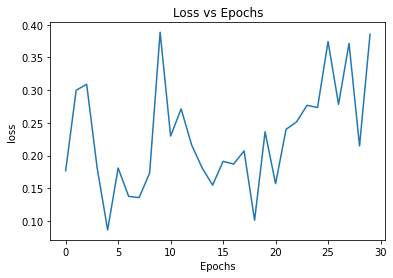

In [38]:
#plotting the loss
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

In [39]:
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [40]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [41]:
print(len(y_pred_list))
print(len(y_test))

61502
61502


In [42]:
# y_pred_list[5]

In [43]:
from collections import Counter
Counter(y_pred_list).keys()

dict_keys([1.0, 0.0])

In [44]:
y_pred_list= [int(a) for a in y_pred_list]
Counter(y_pred_list).keys()

dict_keys([1, 0])

In [45]:
Counter(y_test).keys()

dict_keys([0, 1])

In [46]:
confusion_matrix(y_test, y_pred_list)

array([[    1, 56536],
       [    0,  4965]])

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test,y_pred_list))  
print(accuracy_score(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00     56537
           1       0.08      1.00      0.15      4965

    accuracy                           0.08     61502
   macro avg       0.54      0.50      0.07     61502
weighted avg       0.93      0.08      0.01     61502

0.08074534161490683


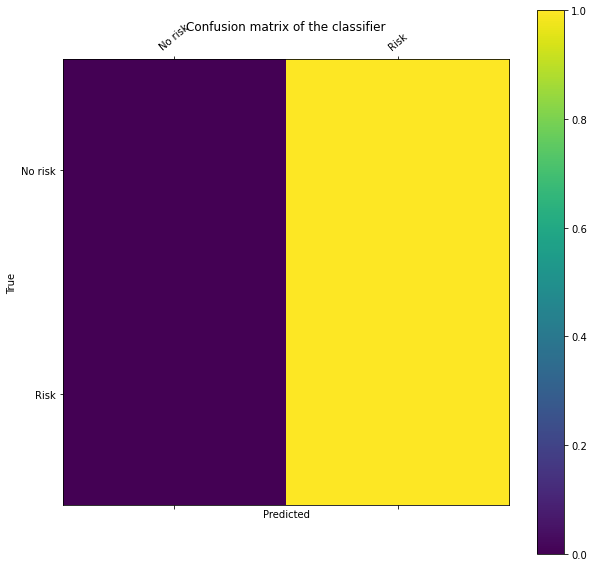

In [48]:

from sklearn.metrics import confusion_matrix

labels = ['No risk', 'Risk']
cm = confusion_matrix(y_test, y_pred_list,normalize='true')
# print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
fig.set_size_inches(10,10)
plt.xticks(rotation=40)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [49]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Net(
  (fc1): Linear(in_features=53, out_features=35, bias=True)
  (fc2): Linear(in_features=35, out_features=35, bias=True)
  (fc3): Linear(in_features=35, out_features=1, bias=True)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


In [50]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [51]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


In [52]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [53]:
model.eval()

Net(
  (fc1): Linear(in_features=53, out_features=35, bias=True)
  (fc2): Linear(in_features=35, out_features=35, bias=True)
  (fc3): Linear(in_features=35, out_features=1, bias=True)
)